Taking a binary mask from our model the follwoing code will produce the area and azimuth angle for each building footprint.

In [19]:
%config Completer.use_jedi = False

In [ ]:
from solaris.data import data_dir
import solaris as sol
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import cv2
import rasterio as rio
import pycocotools.mask as mask_util
import shapely
import math

In [139]:
class Post_Process:
    def __init__(self, coco_file , tif_img, crs= 'EPSG:5703'):
        '''
        class takes model prediction (coco json format) 
        and reference image, for post processing
        Returns, binary mask and dataframe with area and oriantation
        '''
        self.coco_file = coco_file
        self.tif_img = tif_img
        self.crs = crs
        self.geo_df = None
        self.bin_mask = None
        
    
    def get_bin_mask(self, threshold):
        '''Take the '''
        ## Read and parse our json file
        with open(self.coco_file, 'r') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
        
        #poly_loc_list = []
        ## iterate and decode segmentations
        self.bin_mask = np.zeros(obj[0]['segmentation']['size'])

        for i in range(len(obj)):
            # Check the prediction score
            if obj[i]['score'] > threshold:
                seg_dict = {}
                seg_dict = {'size': obj[i]['segmentation']['size'], 'counts' : obj[i]['segmentation']['counts']}
        
                poly = mask_util.decode(seg_dict)[:, :]
            
                self.bin_mask += poly
            
        return  self.bin_mask
        
    
    def get_full_post_process(self, threshold = 0.6):
        '''Full post process mask
        Returns, Tuple (bunary mask and dataFrame)'''
        self.bin_mask = self.get_bin_mask(threshold)
        self.geo_df = self.__get_geo_df()
        self.geo_df = self.__get_area()
        self.geo_df = self.__get_azimuth()
        
        return  self.bin_mask, self.geo_df
        
        
        
    
    def __get_geo_df(self, output_path=None):
        '''
        Takes a tif image and returns a geo dataframe
        '''
        if self.bin_mask is not None:
            
            if output_path:
                sol.vector.mask.mask_to_poly_geojson(pred_arr=self.bin_mask, 
                                                 reference_im=self.tif_img, 
                                                 output_path=output_path,
                                                 output_type='geojson', simplify=True)
            
                self.geo_df= gpd.read_file(output_path)
                # Update projection 
                self.geo_df = self.geo_df.to_crs(self.crs) # in meter

            # datagrame was not saved    
            else:
                geoms = sol.vector.mask.mask_to_poly_geojson(pred_arr=self.bin_mask, 
                                                 reference_im=self.tif_img,  
                                                 output_type='geojson', simplify=True)
                self.geo_df = gpd.GeoDataFrame(geoms, crs=self.crs)     
            
            self.geo_df = self.geo_df.drop(['value'], axis = 1) 
            
        else:
            print("Claclulate binary mask first using get_bin_mask")
            
        return self.geo_df
    
    

        
    
    def __calc_azimuth(self, g):
        '''takes a geometry  and returns the angle'''        
        a = g.minimum_rotated_rectangle
        l = a.boundary
        coords = [c for c in l.coords]
        segments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]
        longest_segment = max(segments, key=lambda x: x.length)

        p1, p2 = [c for c in longest_segment.coords]
        angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
        return angle
    
    def __get_area(self):
        '''
        calculate area for our polygons and append to the geo_df
        '''
        # If it we have the df
        # Get the area and append to the df
        if self.geo_df is not None :
            # Calculate the area
            self.geo_df['area(square feet)'] = ((self.geo_df['geometry'].area)/10.764) # In sequare feet
        else:
            print("No dataframe acquired, yet. Use get_geo_df")

        return self.geo_df
    
    
    def __get_azimuth(self):
        # Make sure we already have the geo_df calculated
        list_azimuth = []
        if self.geo_df is not None :
            for i in range(len(self.geo_df)):
                g = self.geo_df.iloc[i].geometry
                angle = self.__calc_azimuth(g)
                list_azimuth.append(angle)
                
            self.geo_df['Roof_Azimuth'] = list_azimuth
        
        else: 
             print("No dataframe acquired, yet. Use get_geo_df")
        
        return self.geo_df
    
  
        

In [140]:
# Test our pipeline
image = skimage.io.imread(os.path.join(data_dir, 'sample_geotiff.tif'))
mask = cv2.imread('D:/mask.jpg', 0)
coco_file = 'D:/coco_instances_results (2).json'

In [141]:
obj=Post_Process(coco_file, image)
mask, geo_df_full = obj.get_full_post_process()
bin_mask = obj.get_bin_mask(0.6)
geo_df_full

,geometry,area(square feet),Roof_Azimuth
0,"POLYGON ((804.000 10.000, 804.000 11.000, 798....",94.202899,26.565051
1,"POLYGON ((775.000 377.000, 775.000 449.000, 77...",236.064660,90.000000
2,"POLYGON ((723.000 468.000, 723.000 469.000, 72...",147.157191,180.000000
3,"POLYGON ((830.000 822.000, 830.000 823.000, 82...",116.127834,90.000000
4,"POLYGON ((845.000 864.000, 845.000 865.000, 84...",80.174656,180.000000
5,"POLYGON ((866.000 871.000, 866.000 872.000, 86...",64.474173,180.000000
6,"POLYGON ((13.000 871.000, 13.000 872.000, 5.00...",97.361576,180.000000


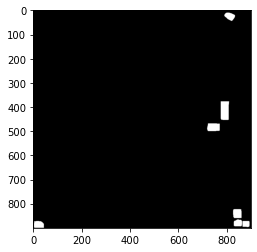

In [143]:
plt.imshow(bin_mask, cmap='gray')

### Reference
- https://epsg.io/
- https://kb.orbitgt.com/209/technology/core/crs
- https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas